# POPPY Simulation: MagAO-X Dark Hole Contrast (version 2PSF, no surf E2E)

## Notes: 
- vAPP coronagraph used is 2PSF with MWFS spots. PDR and PSR used the 1PSF version. 
- The function definitions used in this file may be found here, find the most recent version: https://github.com/jlumbres/magaox_poppy/blob/master/magaoxFunctions.py
- The FITS files used in code (pupil mask, coronagraphs) are not included in github. Contact me and I'll provide a Google Drive download link.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

POPPY Version: 0.9.2.dev11+g1887dd5
Last date this notebook was ran: 2020-08-04


## Global variables for MagAO-X

<b>MWFS Settings (03/2020)</b>: 512 pix sample, 8x oversample (MWFS 2PSF vAPP is 512x512)

<b>PSR Settings (08/2019)</b>: 256 pix sample, 8x oversample (1PSF vAPP)

<b>PDR Settings (05/2017)</b>: 512 pix sample, 3x oversample (holdover from PROPER examples)

## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file. All distances between each MagAO-X element (after F/11 focal plane) can be found using Zemax Merit Function Editor (using RAG and QSUM)
- Current Zemax design version: 11.1

### Optical elements not implemented:
- ADC1
- ADC2
- 9mm Lyot Stop

In [2]:
# declare MagAO-X variables
fr_parm = {'wavelength': 656.3e-9 * u.m,
           'npix': 512, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'surf_off': True}

wavelen = np.round(fr_parm['wavelength'].to(u.nm).value).astype(int)
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2:3}nm'.format(fr_parm['npix'], br, wavelen)

# load the CSV prescription values
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
pupil_filename = 'MagAOX_f11_pupil_{0}_unmasked'.format(fr_parm['npix'])
rx_loc = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}.csv'.format(parm_name)
rx_sys = mf.makeRxCSV(rx_loc)

# acquiring csv numerical values for specifically named optics
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Optical_Element_Number'] > 0:
        test_opt['surf_PSD_filename'] = 'none'
    if test_opt['Name'] == 'Tweeter':
        tweeter_num = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
        vapp_diam = test_opt['Radius_m']*2*u.m
    elif test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number'] 

# vAPP files (rewrite this section with better vAPP files)
vAPP_pixelscl = vapp_diam.value/fr_parm['npix'] # more direct
vAPP_folder = data_dir+'coronagraph/'
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)

# overwrite the pupil file based on pixel sampling
rx_sys[0]['surf_PSD_folder'] = data_dir
rx_sys[0]['surf_PSD_filename'] = pupil_filename
rx_sys[vappTRANS_num]['surf_PSD_folder'] = vAPP_folder
rx_sys[vappOPD_num]['surf_PSD_folder'] = vAPP_folder

## FRESNEL MODE
### Step 1: Generate all the PSFs
Separately calculate the PSF for the leakage, top, and bottom.

In [3]:
%%time
#%memit
#rx_sys = mf.makeRxCSV(rx_nosurf_loc) # version: no surfaces applied
print('[FRESNEL] Calculating all PSFs at wavelength = {0}'.format(fr_parm['wavelength']))

# Build the leakage term
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_sys, fr_parm['npix'], fr_parm['beam_ratio'], 'F69Sci')
leak_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0] # much faster for crunching to intensity!
print('Leakage PSF (0 phase) complete')

# bottom PSF (positive phase coronagraph)
rx_sys['surf_PSD_filename'][vappTRANS_num] = vAPP_trans_filename
rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_posOPD_filename
magaox = mf.csvFresnel(rx_sys, fr_parm['npix'], fr_parm['beam_ratio'], 'F69Sci')
pos_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
print('Bottom PSF (+phase) complete')

# top PSF (negative phase coronagraph)
rx_sys['surf_PSD_filename'][vappOPD_num] = vAPP_negOPD_filename
magaox = mf.csvFresnel(rx_sys, fr_parm['npix'], fr_parm['beam_ratio'], 'F69Sci')
neg_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
print('Top PSF (-phase) complete')

[FRESNEL] Calculating all PSFs at wavelength = 6.563e-07 m
Leakage PSF (0 phase) complete
Bottom PSF (+phase) complete
Top PSF (-phase) complete
CPU times: user 2min 33s, sys: 41.8 s, total: 3min 14s
Wall time: 1min 10s


### Step 2: Complete PSF 
Add the intensities from leakage, negative phase, and positive phase to get the complete 2PSF.

Text(0.5, 1.0, '[FRESNEL] MagAO-X vAPP PSF (NCP DM), no surfaces (I_leak = 0.01, wavelen=0.656um optimized), vAPP platescale fixed')

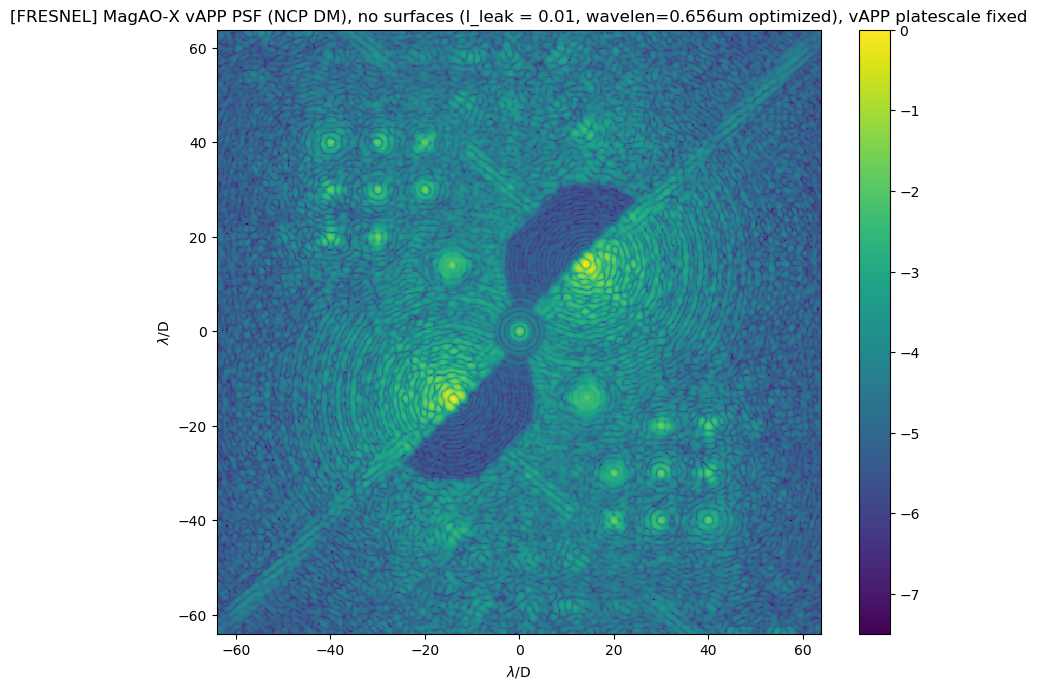

In [4]:
# calculate the lambda/D scale factor per pixel
fnum_det = 69
platescl = 206265*u.arcsec / (pos_psf.header['DIAM']*u.m * fnum_det)
LD_scale = (1/platescl) * (1/(pos_psf.header['PIXELSCL'] * u.m / u.pix)) * (pos_psf.header['DIFFLMT'] * u.arcsec)

# set the scaling range for the plot
box = int(fr_parm['npix']/2)
rk = np.linspace(-box, box, (box*2), endpoint=False) * u.pix
rks = (rk / LD_scale).value

# sum the PSFs
tot_psf = pos_psf.data + neg_psf.data + (leak_psf.data * fr_parm['leak_mult'])

# crop the data
psf_cen = np.int(tot_psf.shape[0]/2)
crop_tot_psf = tot_psf[psf_cen-box:psf_cen+box, psf_cen-box:psf_cen+box]
ctot_psf = crop_tot_psf/crop_tot_psf.max() # set contrast after cropping

# plot the image
plt.figure(figsize=[10,8], dpi=100)
plt.imshow(np.log10(ctot_psf), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)])
plt.colorbar()
plt.xlabel('$\lambda$/D')
plt.ylabel('$\lambda$/D')
plt.title('[FRESNEL] MagAO-X vAPP PSF (NCP DM), no surfaces (I_leak = {0}, wavelen={1:.3}um optimized), vAPP platescale fixed'.format(fr_parm['leak_mult'], fr_parm['wavelength'].value*10**6))

In [29]:
# Write the file (not mandatory)
hdr = copy.copy(pos_psf.header)
del hdr['HISTORY']
hdr.set('PIX_SAMP', npix, 'initial pixel sampling size')
hdr.set('LEAKMULT', leak_mult, 'Multiplier for leakage term intensity')
hdr.set('DIFFMODE', 'Fresnel', 'Diffraction Propagation mode')
fits.PrimaryHDU(ctot_psf, header=hdr).writeto('output/{0}_magaox_2psf_mwfs_nosurfaces_contrast_{1:3}nm.fits'.format(date.today(),np.int(testWavelength.value*10**9)), overwrite=True)

## Fraunhofer comparison

[FRAUNHOFER] Calculating all PSFs at wavelength = 6.563e-07 m
Calculating Leakage PSF
Calculating +phase PSF
Calculating -phase PSF

CPU times: user 5.53 s, sys: 1.17 s, total: 6.7 s
Wall time: 3.3 s


Text(0.5, 1.0, '[FRAUNHOFER] MagAO-X E2E Complete vAPP PSF(I_leak = 0.01, wavelen=0.656um)')

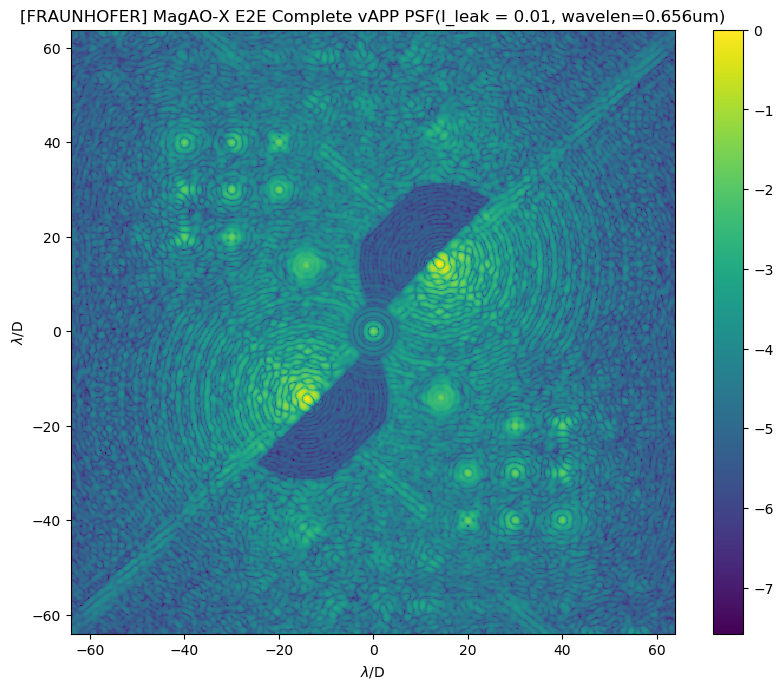

In [5]:
%%time
print('[FRAUNHOFER] Calculating all PSFs at wavelength = {0}'.format(fr_parm['wavelength']))
crop_tot_psf_far = mf.calcFraunhofer_mwfs(fr_parm=fr_parm, 
                                          pupil_file = data_dir + pupil_filename + '.fits',
                                          vapp_folder=vAPP_folder)

# crop the data to the part that matters
ctot_psf_far = crop_tot_psf_far/crop_tot_psf_far.max() # set the contrast

# plot the image
plt.figure(figsize=[10,8], dpi=100)
plt.imshow(np.log10(ctot_psf_far), origin='lower',
          extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)])
plt.colorbar()
plt.xlabel('$\lambda$/D')
plt.ylabel('$\lambda$/D')
plt.title('[FRAUNHOFER] MagAO-X E2E Complete vAPP PSF(I_leak = {0}, wavelen={1:.3}um)'.format(fr_parm['leak_mult'], fr_parm['wavelength'].value*10**6))

In [18]:
# Write the file (not mandatory)
hdr_far = copy.copy(pos_psf_far.header)
del hdr_far['HISTORY']
hdr_far.set('PIX_SAMP', fr_parm['npix'], 'initial pixel sampling size')
hdr_far.set('LEAKMULT', fr_parm['leak_mult'], 'Multiplier for leakage term intensity')
hdr_far.set('DIFFMODE', 'Fraunhofer', 'Diffraction Propagation mode')
fits_loc = home_dir+'output/{0}_magaox_2psf_mwfs_constrast_Fraunhofer_{1}.fits'.format(date.today(),parm_name)
fits.PrimaryHDU(ctot_psf_far, header=hdr_far).writeto(fits_loc, overwrite=True)
#fits.writeto(home_dir+'output/{0}_magaox_2psf_mwfs_nosurfaces_contrast_{1}.fits'.format(date.today(), parm_name), overwrite=True)

## Building the DH mask
Using ds9 and the Fraunhofer output

In [6]:
# initialize the Masking parameters
# move the shifting numbers around based on getting the lowest possible DH contrast
mask_dict = {'mask_size': fr_parm['npix'],
             'cbot_cen': [200, 200],
             'ctop_cen': [317, 312],# [y,x] in ds9
             'c_radius': 70,
             'rect_corner': np.array([149, 55]), # bottom left corner at 0 deg rotation
             'rect_side': np.array([52, 140]), # [y,x] for size in ds9
             'rect_angle': -45,
             'rect_shift_top': [67, 2], # axis [0,1] order (vert, horz)
             'rect_shift_bot': [2, 2] #axis [0, 1] order (vert, horz)
            }

psf_top, psf_bot, mask_top, mask_bot = mf.build_mwfs_masks(mask_dict=mask_dict, write_masks=False)
mask_full = mask_bot + mask_top

dh_top_far = mf.calc_mwfs_dh(mwfs_psf=crop_tot_psf_far, psf_mask=psf_top, dh_mask=mask_top)
dh_bot_far = mf.calc_mwfs_dh(mwfs_psf=crop_tot_psf_far, psf_mask=psf_bot, dh_mask=mask_bot)
dh_top_near = mf.calc_mwfs_dh(mwfs_psf=crop_tot_psf, psf_mask=psf_top, dh_mask=mask_top)
dh_bot_near = mf.calc_mwfs_dh(mwfs_psf=crop_tot_psf, psf_mask=psf_bot, dh_mask=mask_bot)

print('PSF calculation based on Wavelength = {0:3}nm, leak mult = {1:3}\n- using fp distances optimized for {0:3}nm\n- Proper vAPP pixelscaling'.format(wavelen, fr_parm['leak_mult']))
print('{0:^5} | {1:^10} | {2:^10}'.format('DH', 'Fresnel', 'Fraunhofer'))
print('{0:^5} | {1:^10.3e} | {2:^10.3e}'.format('top', dh_top_near, dh_top_far))
print('{0:^5} | {1:^10.3e} | {2:^10.3e}'.format('bot', dh_bot_near, dh_bot_far))

PSF calculation based on Wavelength = 656nm, leak mult = 0.01
- using fp distances optimized for 656nm
- Proper vAPP pixelscaling
 DH   |  Fresnel   | Fraunhofer
 top  | 5.983e-06  | 4.439e-06 
 bot  | 5.746e-06  | 4.580e-06 


/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'Fresnel DH mask (I_leak = 0.01, wavelen=656nm)')

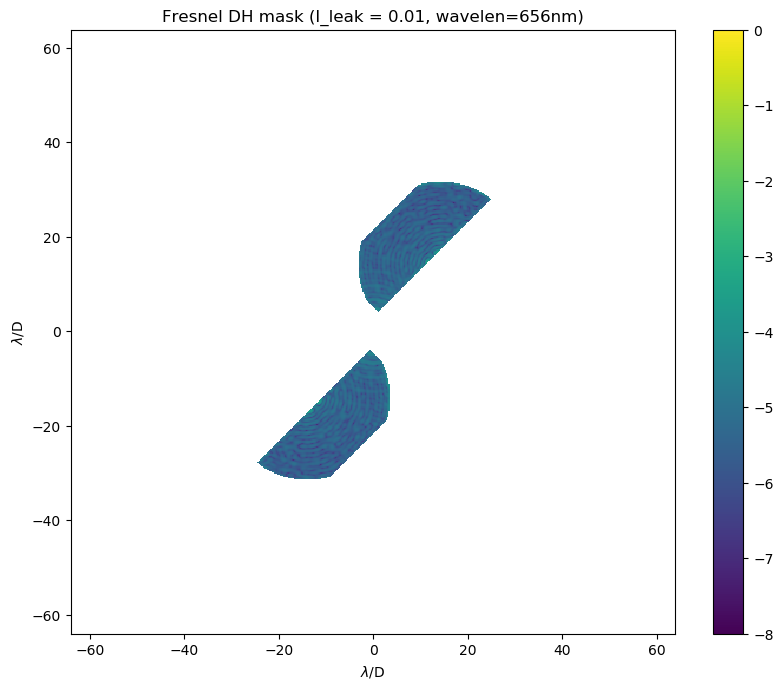

In [7]:
plt.figure(figsize=[10,8], dpi=100)
plt.imshow(np.log10(mask_full*crop_tot_psf/crop_tot_psf.max()), origin='lower', vmax=0, vmin=-8,
            extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)])
plt.colorbar()
plt.xlabel('$\lambda$/D')
plt.ylabel('$\lambda$/D')
plt.title('Fresnel DH mask (I_leak = {0}, wavelen={1}nm)'.format(fr_parm['leak_mult'], wavelen))

/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'Fraunhofer DH mask (I_leak = 0.01, wavelen=656nm)')

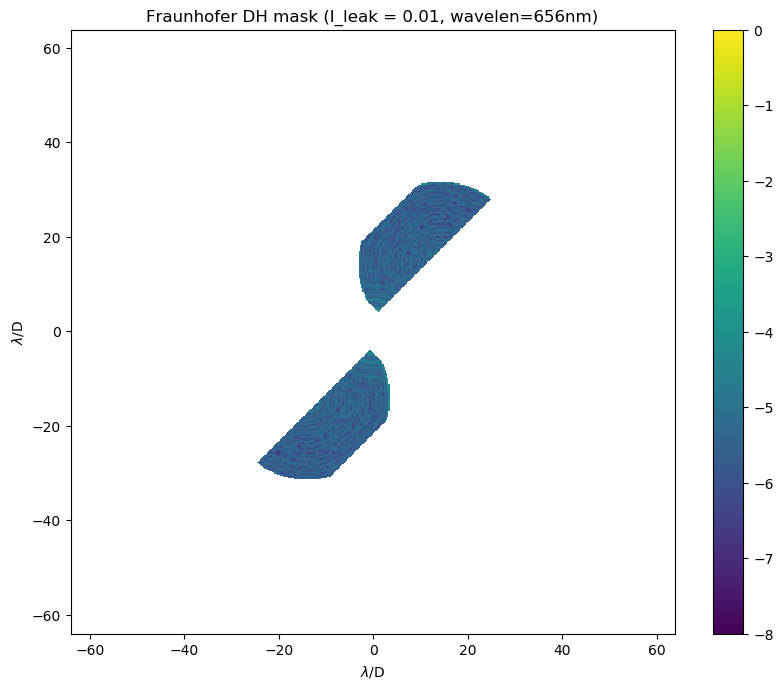

In [8]:
plt.figure(figsize=[10,8], dpi=100)
plt.imshow(np.log10(mask_full*crop_tot_psf_far/crop_tot_psf_far.max()), origin='lower', vmax=0, vmin=-8,
                    extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)])
plt.colorbar()
plt.xlabel('$\lambda$/D')
plt.ylabel('$\lambda$/D')
plt.title('Fraunhofer DH mask (I_leak = {0}, wavelen={1}nm)'.format(fr_parm['leak_mult'], wavelen))

### Reference code
Try to not throw away code. You always end up regretting it.

In [ ]:
# top mask
circ_top = np.zeros((side, side), dtype=np.uint8)
ct_coords = draw.circle(567, 562, radius=circ_rad, shape=circ_top.shape)
circ_top[ct_coords] = True

rect_top = np.zeros((side, side), dtype=np.uint8)
#rcen = np.array([286, 390]) # backwards on ds9
rst_top = np.array([564, 375]) # bottom left corner when not rotated in ds9; backwards of x and y
rr,cc = draw.rectangle(rst_top, extent=rside, shape=rect_top.shape)
rect_top[rr,cc] = 1
rect_top_rot = np.roll(scipy.ndimage.rotate(rect_top, psf_rot_deg, reshape=False), rect_shift)